<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/caseStudy_Jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

### Background

This case study is losely based on an actual market research problem. The client tested a (relatively) large number of advertising messages over the years. These tests involved respondents evaluating the credibility and appeal of those messages. These evaluations are aggregated to a score which is then binned using deciles. Top decile claims are likely to be used in actual advertising campaigns. 

We try to predict the claim performance (as represented by the decile) from the text by applying a popular pre-trained model.

### Your task

Fill in the blanks to make a basic analysis work. Add to it as much as you like. During the subsequent interview, you can explain your solution and approach.

### Data

There are three column in the data, `Message_Text` (The advertising message), `score` (The survey-based score) and `label` (Decile).

Our client wants to predict `label` from `Message_Text`. There are 10 classes in total.

The data structure is based on real data, however, for confidentiality reasons it is not our actual client data.

### Model

The code below apply *distilbert model* to do the classification. Please fill the blanks.

We will use pretraiend model from [huggingface](https://huggingface.co/) library. Hugginface is an open source AI library where published cutting-edge advanced AI models. You can find [courses](https://huggingface.co/course/chapter1/1) online.
 
This case study is [text classification](https://huggingface.co/tasks/text-classification) task.
If you are not familiar with [Bert](https://en.wikipedia.org/wiki/BERT_(language_model)), please check this [paper](https://arxiv.org/abs/1810.04805). Please also check [attention machenism](https://arxiv.org/abs/1706.03762) and transformer. 

###Setup

In [127]:
!pip install transformers --quiet 
!pip install datasets --quiet
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --quiet
!pip install psutil --quiet
!pip install humanize --quiet

import psutil
import humanize
import os
import GPUtil as GPU

In [96]:
# check GPU unit

GPUs = GPU.getGPUs()
gpu = GPUs[0]  # Only one GPU on Colab and not guaranteed

def print_mem():
  """Prints stats for ram and graphic memory"""

  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " | Used: " + humanize.naturalsize(process.memory_info().rss))
  print("VRAM Free: {0:.0f}MB | Used: {1:.0f}MB | Using {2:3.0f}% Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil * 100, gpu.memoryTotal))

print_mem()

RAM Free: 9.3 GB  | Used: 4.4 GB
VRAM Free: 13037MB | Used: 3243MB | Using  20% Total 16280MB


In [128]:
# mount google drive for workspace

from google.colab import drive

def mount_gdrive():
  """Sets up google drive directory access"""
  path = "/content/drive"
  drive.mount(path, force_remount=True)
  
my_dir = "/content/drive/MyDrive/CaseStudySkim/"
mount_gdrive()
print(os.listdir(my_dir))

Mounted at /content/drive
['sampled_data_NLP.xltx', 'caseStudy_Jan.ipynb']


###Data Exploration

In [129]:
import pandas as pd

data = pd.read_excel(my_dir + "sampled_data_NLP.xltx")
print("Shape: ", data.shape, "\n")
data.head()

Shape:  (7211, 3) 



,Message_Text,label,score
0,Impeccable stain removal,class7,0.634615
1,With Odour Resistance Formula - Still fresh at...,class9,0.875000
2,Original recipe,class8,0.788462
3,Natural hair gene awakening for 1000 new hair ...,class4,0.383333
4,Plastic-free packaging,class5,0.483871


In [130]:
symbol_example1 = 1254
symbol_example2 = 1649
dutch_example = 2000
spanish_example = 1104
print("Unwanted characters: \n\n", data.iloc[symbol_example1], "\n")
print(data.iloc[symbol_example2], "\n")
print("Non-english languages: \n\n", data.iloc[dutch_example], "\n")
print(data.iloc[spanish_example])

Unwanted characters: 

 Message_Text    Yumos: 2 fragrances in 1¬†fabcon - every time ...
label                                                      class2
score                                                    0.105263
Name: 1254, dtype: object 

Message_Text    "It‚Äôs better than any other Deodorants that ...
label                                                     class10
score                                                    0.928571
Name: 1649, dtype: object 

Non-english languages: 

 Message_Text    Vrij van conserveermiddelen
label                                class5
score                              0.433333
Name: 2000, dtype: object 

Message_Text    Textura ideal con muchos tomates
label                                     class9
score                                       0.85
Name: 1104, dtype: object


### Preprocessing

In [131]:
!pip install googletrans==4.0.0rc1 --quiet
!pip install langid --quiet

from googletrans import Translator
import langid

In [132]:
# Delete unwanted characters

def filter_chars(string):
  """Removes all non printable ascii characters from given string"""
  return ''.join(["" if ord(i) < 32 or ord(i) > 126 else i for i in string])

data["Message_Text"] = data["Message_Text"].apply(filter_chars)

print(data.iloc[symbol_example1], "\n")
print(data.iloc[symbol_example2])

Message_Text    Yumos: 2 fragrances in 1fabcon - every time yo...
label                                                      class2
score                                                    0.105263
Name: 1254, dtype: object 

Message_Text    "Its better than any other Deodorants that I h...
label                                                     class10
score                                                    0.928571
Name: 1649, dtype: object


In [133]:
# Remove non-english languages 
# Translate? some frases that sound cool or catchy in english stop having that property when translated

translator = Translator()
def detect_lang_google(string, translator=translator):
  """Given a string, use Google API to check if its in english"""
  try:
    ret = translator.detect(string).lang == "en"
  except Exception as err:
    print(string, err)
    ret = False
  return ret

def detect_lang(string):
  """Given a string, use langid to check if its in english"""
  return langid.classify(string)[0] == "en"
#print(langid.classify("More space, better taste"))

data_noneng = data[data["Message_Text"].map(detect_lang) == False]
data_eng = data[data["Message_Text"].map(detect_lang) == True]

pct_lost = round((1 - (data_eng.shape[0] / data.shape[0])) * 100, 1)
print("\nDataset reduced to {} from {} examples ({}% removed)".format(data_eng.shape[0], data.shape[0], pct_lost))



Dataset reduced to 6438 from 7211 examples (10.7% removed)


In [134]:
# Make sure we still have balanced classes

def get_pct(value, total=data_eng.shape[0]):
  """Calculates percentage of total dataset"""
  pct = round((value / total) * 100, 1)
  return str(pct) + "%"

amount = data_eng.label.value_counts()
percentages = data_eng.label.value_counts().apply(get_pct)
balance_check = pd.concat([amount, percentages], axis=1)
balance_check

,label,label
class10,732,11.4%
class3,686,10.7%
class4,669,10.4%
class8,658,10.2%
class5,651,10.1%
class9,635,9.9%
class6,631,9.8%
class2,630,9.8%
class7,605,9.4%
class1,541,8.4%


In [135]:
# Cast string label to one hot encoding

def one_hot_label(str_label):
  """Given a class string, return it as one hot list"""
  one_hot_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  idx = int(str_label.strip("class")) - 1
  one_hot_list[idx] = 1

  return one_hot_list

data_ready = data_eng.copy()
data_ready["label"] = data_eng["label"].map(one_hot_label)
data_ready

,Message_Text,label,score
1,With Odour Resistance Formula - Still fresh at...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",0.875000
2,Original recipe,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",0.788462
3,Natural hair gene awakening for 1000 new hair ...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",0.383333
4,Plastic-free packaging,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0.483871
5,Blended with the most luxurious fragrances for...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0.476190
...,...,...,...
7206,Every drop actively removes stains,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",0.428571
7207,"Indulge your senses with a richer, more foamy cup","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.055556
7208,CIF Cream with microparticles acts deep into t...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.021739
7209,With Patented Technology to refresh your senses,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0.980000


In [136]:
# Convert pandas into dataset and get train and test samples
from datasets import Dataset

ds = (Dataset.from_pandas(data_ready, preserve_index=False).train_test_split(train_size=0.8, test_size=0.2))
print("Train set: ", len(ds["train"]), "examples")
print("Test set: ", len(ds["test"]), "examples")

# peek at one example
ds["train"][0]

Train set:  5150 examples
Test set:  1288 examples


{'Message_Text': 'The only 48h antiperspirant designed for your skin',
 'label': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'score': 0.5}

## Tokenizer

We are using huggingface [AutoClass](https://huggingface.co/docs/transformers/model_doc/auto). For the [tokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer), please check here.

In [137]:
import torch
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification,
                          DistilBertTokenizer,
                          TrainingArguments, 
                          Trainer)

In [138]:
# Instantiate tokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# same as
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

In [139]:
# Tokenize dataset messages

def tokenize_and_encode(examples):
    return tokenizer(examples["Message_Text"], truncation=True)

cols = ds["train"].column_names
cols.remove("label")
ds_enc = ds.map(tokenize_and_encode, batched=True, remove_columns=cols)
print("\n Training example \n", ds_enc["train"][0],  "\n")

ds_enc

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]


 Training example 
 {'label': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 'input_ids': [101, 1996, 2069, 4466, 2232, 3424, 7347, 8197, 17884, 2881, 2005, 2115, 3096, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 



DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 5150
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1288
    })
})

In [140]:
# cast to tensors

ds_enc.set_format("torch")
ds_enc = (ds_enc
          .map(lambda x : {"float_label": x["label"].to(torch.float)}, remove_columns=["label"])
          .rename_column("float_label", "label"))
print("\n Training example in tensor \n")
ds_enc["train"][0]

  0%|          | 0/5150 [00:00<?, ?ex/s]

  0%|          | 0/1288 [00:00<?, ?ex/s]


 Training example in tensor 



{'input_ids': tensor([  101,  1996,  2069,  4466,  2232,  3424,  7347,  8197, 17884,  2881,
          2005,  2115,  3096,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'label': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])}

## Model

In [148]:
AMOUNT_CLASSES = 10
DROPOUT = 0.25

model = (AutoModelForSequenceClassification
         .from_pretrained(
            "distilbert-base-uncased",
            num_labels=AMOUNT_CLASSES,
            dropout=DROPOUT
          ).to("cuda")
        )

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.25,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_position_embeddings": 51

In [149]:
# let's peek the data
print(ds_enc["train"][0])

{'input_ids': tensor([  101,  1996,  2069,  4466,  2232,  3424,  7347,  8197, 17884,  2881,
         2005,  2115,  3096,   102]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'label': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])}


In [150]:
# Write custom accuracy function

import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(eval_pred):
  """Measures accuracy as percentage of exact matches"""

  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=1)
  numbered_labels = np.argmax(labels, axis=1)

  return metric.compute(predictions=predictions, references=numbered_labels)

In [151]:
BATCH_SIZE = 8
NUM_EPOCHS = 6

args = TrainingArguments(
    output_dir=my_dir,
    overwrite_output_dir=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    save_strategy="epoch",
    learning_rate = 3e-5
)

trainer = Trainer(model=model, 
                  args=args, 
                  train_dataset=ds_enc["train"], 
                  eval_dataset=ds_enc["test"], 
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics
                  )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [152]:
trainer.train()

***** Running training *****
  Num examples = 5150
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3864


Epoch,Training Loss,Validation Loss,Accuracy
1,0.339500,0.321461,0.159938
2,0.321800,0.314948,0.182453
3,0.316600,0.316412,0.171584
4,0.295300,0.321901,0.145186
5,0.284500,0.326984,0.156832
6,0.277300,0.332166,0.143634


***** Running Evaluation *****
  Num examples = 1288
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/CaseStudySkim/checkpoint-644
Configuration saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-644/config.json
Model weights saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-644/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-644/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-644/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1288
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/CaseStudySkim/checkpoint-1288
Configuration saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-1288/config.json
Model weights saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-1288/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-1288/tokenizer_config.json
Special tokens file sav

TrainOutput(global_step=3864, training_loss=0.3028644775011525, metrics={'train_runtime': 169.2576, 'train_samples_per_second': 182.562, 'train_steps_per_second': 22.829, 'total_flos': 199350475920000.0, 'train_loss': 0.3028644775011525, 'epoch': 6.0})

##Results

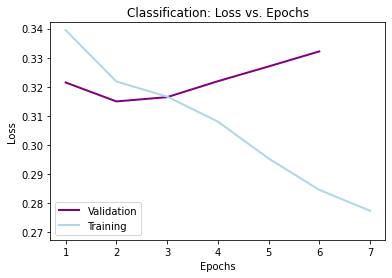

In [153]:
# Plot model log data

import matplotlib.pyplot as plt

def process_log_history(log_history):
  """Extract lists of train and validation loss from log history"""

  train_loss = []
  eval_loss = []
  for step_info in log_history:
    if "epoch" in step_info:
      if "eval_loss" in step_info:
        eval_loss.append(step_info["eval_loss"])
      elif "loss" in step_info:
        train_loss.append(step_info["loss"])

  return train_loss, eval_loss

train_loss, eval_loss = process_log_history(trainer.state.log_history)

plt.title("Classification: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1, len(eval_loss) + 1), eval_loss, label="Validation", color="purple", linewidth=2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training", color="lightblue", linewidth=2)
plt.ylim((min(train_loss) - 0.01, max(eval_loss) + 0.01))
plt.xticks(np.arange(1, len(train_loss) + 1, 1))
plt.legend()
plt.show()

In [154]:
# Run some predictions

from transformers import pipeline

def predict_advertising(text, model=model, tokenizer=tokenizer):
  """Runs input text through model to return decile prediction"""

  model.to("cpu") # keep data and model on same device
  prediction_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
  result = prediction_pipeline([text])
  result_decile = int(model.config.label2id[result[0]["label"]]) + 1
  
  return f"Decile {result_decile} is predicted for '{text}'"

test_ads = ["Yes, buy this product.",
            "Amazing deodorant at low cost! You won't regret it",
            "Great performance and natural ingredients, keeps you dry all day!"
            ]
            
for ad in test_ads:
  print(predict_advertising(ad))


Decile 9 is predicted for 'Yes, buy this product.'
Decile 8 is predicted for 'Amazing deodorant at low cost! You won't regret it'
Decile 1 is predicted for 'Great performance and natural ingredients, keeps you dry all day!'


# Improvement?

Congrats! You finish your model training.

But this is a very basic model, there are still lots of improvements could be done. 

For example, improving model accuracy by tuning hyperparameter, changing different models, logging model to diagnose models. 
You could also try explinable AI to interpret why model gives this prediction. 

Client is also interested in directly predicting socres, you could also try that.

Have fun!

In [155]:
AMOUNT_CLASSES = 1
DROPOUT = 0.2

regression_model = (AutoModelForSequenceClassification
                    .from_pretrained(
                        "distilbert-base-uncased",
                        problem_type="regression",
                        num_labels=AMOUNT_CLASSES,
                        dropout=DROPOUT
                        ).to("cuda")
                      )

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.2,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "regression",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.3",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert

In [156]:
# Change label column to scores

data_reg = data_ready.copy()
data_reg = data_reg.drop(columns="label").rename(columns={"score": "label"})
data_reg

,Message_Text,label
1,With Odour Resistance Formula - Still fresh at...,0.875000
2,Original recipe,0.788462
3,Natural hair gene awakening for 1000 new hair ...,0.383333
4,Plastic-free packaging,0.483871
5,Blended with the most luxurious fragrances for...,0.476190
...,...,...
7206,Every drop actively removes stains,0.428571
7207,"Indulge your senses with a richer, more foamy cup",0.055556
7208,CIF Cream with microparticles acts deep into t...,0.021739
7209,With Patented Technology to refresh your senses,0.980000


In [157]:
# Convert pandas into dataset and get train and test samples

ds_reg = (Dataset.from_pandas(data_reg, preserve_index=False).train_test_split(train_size=0.8, test_size=0.2))
print("Train set: ", len(ds_reg["train"]), "examples")
print("Test set: ", len(ds_reg["test"]), "examples")

# peek at one example
ds_reg["train"][0]

Train set:  5150 examples
Test set:  1288 examples


{'Message_Text': 'The only 48h antiperspirant designed for your skin',
 'label': 0.5}

In [158]:
# Tokenize dataset messages

cols = ds_reg["train"].column_names
cols.remove("label")
ds_reg_enc = ds_reg.map(tokenize_and_encode, batched=True, remove_columns=cols)
print("\n Training example \n", ds_reg_enc["train"][0],  "\n")

ds_reg_enc

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]


 Training example 
 {'label': 0.5, 'input_ids': [101, 1996, 2069, 4466, 2232, 3424, 7347, 8197, 17884, 2881, 2005, 2115, 3096, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 



DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 5150
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1288
    })
})

In [159]:
# cast to tensors

ds_reg_enc.set_format("torch")
print("\n Training example in tensor \n")
ds_reg_enc["train"][0]


 Training example in tensor 



{'label': tensor(0.5000),
 'input_ids': tensor([  101,  1996,  2069,  4466,  2232,  3424,  7347,  8197, 17884,  2881,
          2005,  2115,  3096,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [160]:
# Write custom accuracy function for regression

def compute_metrics(eval_pred):
  """ Measures accuracy as percentage of estimations with less error than threshold"""
  
  THRESHOLD = 0.1
  logits, labels = eval_pred
  predictions = np.squeeze(logits)
  total = len(labels)
  correct = 0
  for i in range(len(labels)):
    if abs(labels[i] - predictions[i]) <= THRESHOLD:
      correct += 1
  acc = correct / total

  return { "accuracy": acc }

In [161]:
BATCH_SIZE = 8
NUM_EPOCHS = 6

reg_args = TrainingArguments(
    output_dir=my_dir,
    overwrite_output_dir=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="epoch",
    num_train_epochs=NUM_EPOCHS,
    save_strategy="epoch",
    learning_rate = 5e-5
    )

reg_trainer = Trainer(
    model=regression_model, 
    args=args, 
    train_dataset=ds_reg_enc["train"], 
    eval_dataset=ds_reg_enc["test"], 
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [162]:
reg_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5150
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3864


Epoch,Training Loss,Validation Loss,Accuracy
1,0.084400,0.074990,0.225155
2,0.070200,0.068384,0.274068
3,0.060900,0.073807,0.274845
4,0.034500,0.075383,0.261646
5,0.025100,0.078864,0.271739
6,0.022100,0.082622,0.281056


***** Running Evaluation *****
  Num examples = 1288
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/CaseStudySkim/checkpoint-644
Configuration saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-644/config.json
Model weights saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-644/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-644/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-644/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1288
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/CaseStudySkim/checkpoint-1288
Configuration saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-1288/config.json
Model weights saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-1288/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CaseStudySkim/checkpoint-1288/tokenizer_config.json
Special tokens file sav

TrainOutput(global_step=3864, training_loss=0.046157011457605146, metrics={'train_runtime': 168.8417, 'train_samples_per_second': 183.012, 'train_steps_per_second': 22.885, 'total_flos': 199318484289600.0, 'train_loss': 0.046157011457605146, 'epoch': 6.0})

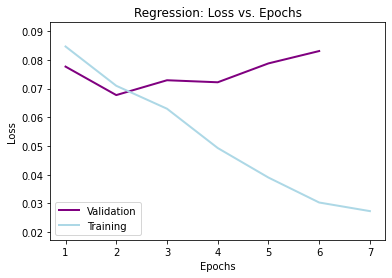

In [125]:
# Plot regression model log data

reg_train_loss, reg_eval_loss = process_log_history(reg_trainer.state.log_history)

plt.title("Regression: Loss vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1, len(reg_eval_loss) + 1), reg_eval_loss, label="Validation", color="purple", linewidth=2)
plt.plot(range(1, len(reg_train_loss) + 1), reg_train_loss, label="Training", color="lightblue", linewidth=2)
plt.ylim((min(reg_train_loss) - 0.01, max(reg_eval_loss) + 0.01))
plt.xticks(np.arange(1, len(reg_train_loss) + 1, 1))
plt.legend()
plt.show()

In [126]:
# Run some predictions

from transformers import pipeline

def predict_advertising_reg(text, model=regression_model, tokenizer=tokenizer):
  """Runs input text through model to return score prediction"""

  model.to("cpu") # keep data and model on same device
  prediction_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
  result = prediction_pipeline([text])
  result_score = round(result[0]["score"], 2)
  
  return f"Score of {result_score} is predicted for '{text}'"

test_ads = ["Yes, buy this product.",
            "Amazing deodorant at low cost! You won't regret it",
            "Great performance and natural ingredients, keeps you dry all day!"
            ]
            
for ad in test_ads:
  print(predict_advertising_reg(ad))

Score of 0.73 is predicted for 'Yes, buy this product.'
Score of 0.66 is predicted for 'Amazing deodorant at low cost! You won't regret it'
Score of 0.51 is predicted for 'Great performance and natural ingredients, keeps you dry all day!'
